# Customize PySM models

There are 3 straightforward ways to customize PySM models.

First we can still keep the same algorithms used to generate the components and just provide different templates/paramers, we can achieve this either [using configuration files](#use_a_configuration_file) or, for more flexibility, [work directly with the component Python object](#work_with_python_class).

Instead if we need to implement different algorithms, we need to [implement a subclass of pysm3.Model](#implement_a_subclass_of_pysm.Model)

In [1]:
import pysm3
import pysm3.units as u
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Use a configuration file

The PySM models are implemented as classes and are then configured with input parameters in [`presets.cfg`](https://github.com/galsci/pysm/blob/main/pysm3/data/presets.cfg), the same facilities used to load that configuration file and create the component object can be leverage by creating our own `cfg` file, for example here we are using a scalar value for `map_mbb_index` instead of using the template map provided in the `d1` model.
But we could as well replace the maps with our own custom maps.

The `%%file` magic creates a file with the content of the cell

In [2]:
%%file mydust.cfg

[dustfixedspec]
class = "ModifiedBlackBody"
map_I = "pysm_2/dust_t_new.fits"
map_Q = "pysm_2/dust_q_new.fits"
map_U = "pysm_2/dust_u_new.fits"
unit_I = "uK_RJ"
unit_Q = "uK_RJ"
unit_U = "uK_RJ"
map_mbb_index = 1.5
map_mbb_temperature = "pysm_2/dust_temp.fits"
unit_mbb_temperature = "K"
freq_ref_I = "545 GHz"
freq_ref_P = "353 GHz"

Overwriting mydust.cfg


In [3]:
sky_mydust = pysm3.Sky(nside=128, component_config="mydust.cfg")

In [4]:
sky_d1 = pysm3.Sky(nside=128, preset_strings=["d1"])

In [5]:
map_100GHz_mydust = sky_mydust.get_emission(100 * u.GHz)

In [6]:
map_100GHz_d1 = sky_d1.get_emission(100 * u.GHz)

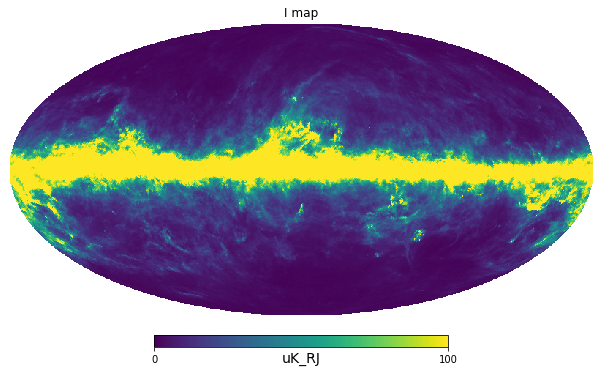

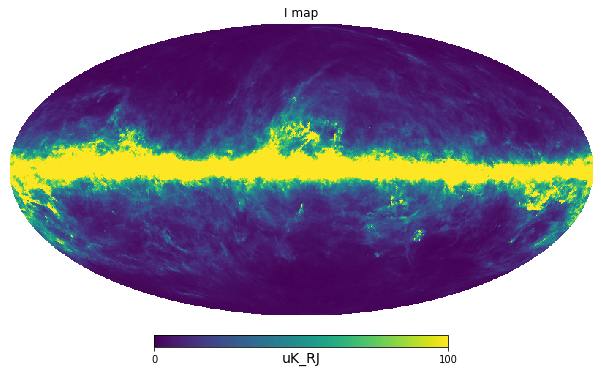

In [7]:
hp.mollview(map_100GHz_mydust[0], min=0, max=100, title="I map", unit=map_100GHz_d1.unit)
hp.mollview(map_100GHz_d1[0], min=0, max=100, title="I map", unit=map_100GHz_d1.unit)

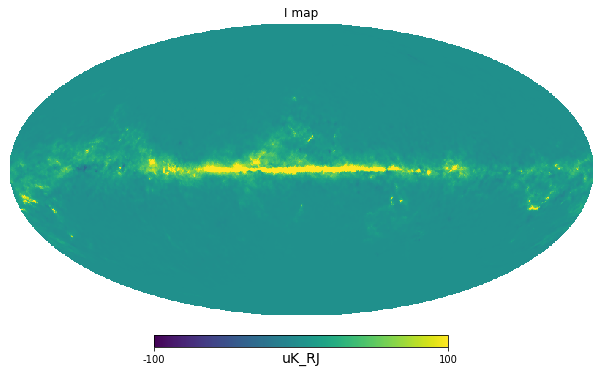

In [8]:
hp.mollview(map_100GHz_mydust[0] - map_100GHz_d1[0], min=-100, max=100, title="I map", unit=map_100GHz_d1.unit)

## Work with the component class

We have more flexibility if we use the component class itself, we can create an instance and we can provide different input parameters and that is equivalent of using a configuration file.

But we can also create the class and then modify in place the class attributes, see an example below:

In [9]:
dust = pysm3.ModifiedBlackBody(
    nside = 128,
    map_I = "pysm_2/dust_t_new.fits",
    map_Q = "pysm_2/dust_q_new.fits",
    map_U = "pysm_2/dust_u_new.fits",
    unit_I = "uK_RJ",
    unit_Q = "uK_RJ",
    unit_U = "uK_RJ",
    map_mbb_index = "pysm_2/dust_beta.fits",
    map_mbb_temperature = "pysm_2/dust_temp.fits",
    unit_mbb_temperature = "K",
    freq_ref_I = "545 GHz",
    freq_ref_P = "353 GHz"
)

In [10]:
dust.mbb_temperature *= .8

In [11]:
map_100GHz_mydust = dust.get_emission(100 * u.GHz)

In [12]:
sky_d1 = pysm3.Sky(nside = 128, preset_strings=["d1"])

In [13]:
map_100GHz_d1 = sky_d1.get_emission(100 * u.GHz)

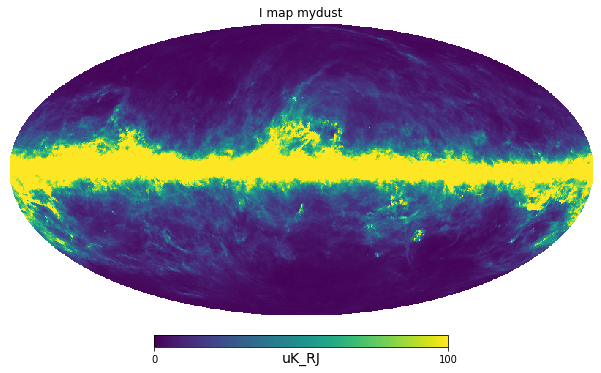

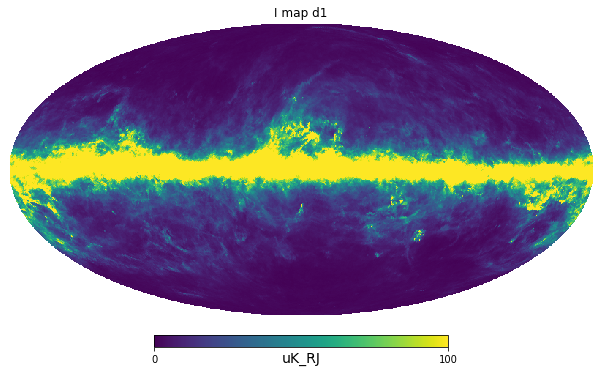

In [14]:
hp.mollview(map_100GHz_mydust[0], min=0, max=100, title="I map mydust", unit=map_100GHz_d1.unit)
hp.mollview(map_100GHz_d1[0], min=0, max=100, title="I map d1", unit=map_100GHz_d1.unit)

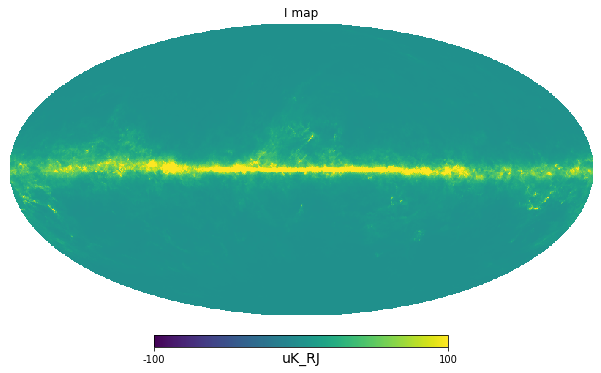

In [15]:
hp.mollview(map_100GHz_mydust[0] - map_100GHz_d1[0], min=-100, max=100, title="I map", unit=map_100GHz_d1.unit)

## Implement a subclass of pysm3.Model

In order to implement your own model, subclass `pysm3.Model` and implement the `get_emission` method which gets an array of frequency `freqs` and a bandpass `weights` and performs the computation and bandpass integration and returns the output in `uK_RJ`.

If we want to reuse some of the algorithms implemented in one of the PySM classes, it is possible to directly subclass one of those instead of starting from `pysm3.Model`.

In [17]:
class Monopole(pysm3.Model):
    def __init__(self, nside, value, map_dist=None):
        super().__init__(nside=nside, map_dist=map_dist)
        self.value = value << u.uK_RJ
    def get_emission(self, freqs, weights=None):
        return np.ones((3, hp.nside2npix(self.nside))) * self.value

In [18]:
monopole = Monopole(nside=128, value=1*u.mK_RJ)

In [19]:
monopole.get_emission(10 * u.GHz)

<Quantity [[1000., 1000., 1000., ..., 1000., 1000., 1000.],
           [1000., 1000., 1000., ..., 1000., 1000., 1000.],
           [1000., 1000., 1000., ..., 1000., 1000., 1000.]] uK_RJ>

In [20]:
sky = pysm3.Sky(nside=128, preset_strings=["d1"], component_objects=[monopole])

In [21]:
sky.get_emission(100 * u.GHz)[0, :3]

<Quantity [1001.28953111, 1001.34435272, 1001.55604219] uK_RJ>

For performance better use `numba` to make use of all cores on the machine and execute at compiled code speed, for example:

<https://github.com/galsci/pysm/blob/main/pysm3/models/power_law.py>